# Evaluation using QCB chemicals (medium)

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from os.path import exists

sys.path.append('../..')

In [3]:
import pylab as plt
import pandas as pd
import numpy as np
from loguru import logger
import seaborn as sns

from stable_baselines3 import DQN, PPO
from sb3_contrib import RecurrentPPO

In [4]:
from vimms.Common import POSITIVE, set_log_level_warning, load_obj, save_obj
from vimms.ChemicalSamplers import UniformRTAndIntensitySampler, GaussianChromatogramSampler, UniformMZFormulaSampler, \
    MZMLFormulaSampler, MZMLRTandIntensitySampler, MZMLChromatogramSampler
from vimms.Noise import UniformSpikeNoise
from vimms.Evaluation import evaluate_real
from vimms.Chemicals import ChemicalMixtureFromMZML
from vimms.Roi import RoiBuilderParams, SmartRoiParams

from mass_spec_utils.data_import.mzmine import load_picked_boxes

from vimms_gym.env import DDAEnv
from vimms_gym.chemicals import generate_chemicals
from vimms_gym.evaluation import evaluate, run_method
from vimms_gym.common import METHOD_RANDOM, METHOD_FULLSCAN, METHOD_TOPN, METHOD_DQN, \
    METHOD_DQN_COV, METHOD_DQN_INT, METHOD_DQN_MID, METHOD_PPO, METHOD_PPO_RECURRENT

# 1. Parameters

Parameters that will be used throughout this notebook. Should be the same as the training ones.

Chemical generation parameters

In [5]:
from experiments import preset_qcb_medium
alpha = 0.50
beta = 0.50
extract = True
params, max_peaks = preset_qcb_medium(None, alpha=alpha, beta=beta, extract_chromatograms=extract)
params, max_peaks

2022-11-22 16:20:36.668 | INFO     | experiments:get_samplers:249 - Loaded /Users/joewandy/Work/git/vimms-gym/pickles/samplers_QCB_medium_extracted.p


({'chemical_creator': {'mz_range': (100, 600),
   'rt_range': (400, 800),
   'intensity_range': (10000.0, 1e+20),
   'n_chemicals': (200, 500),
   'mz_sampler': <vimms.ChemicalSamplers.MZMLFormulaSampler at 0x7fe479a34ac0>,
   'ri_sampler': <vimms.ChemicalSamplers.MZMLRTandIntensitySampler at 0x7fe4aad56280>,
   'cr_sampler': <vimms.ChemicalSamplers.MZMLChromatogramSampler at 0x7fe4aad72520>},
  'noise': {'enable_spike_noise': True,
   'noise_density': 0.1,
   'noise_max_val': 1000.0,
   'mz_range': (100, 600)},
  'env': {'ionisation_mode': 'Positive',
   'rt_range': (400, 800),
   'isolation_window': 0.7,
   'mz_tol': 10,
   'rt_tol': 120,
   'alpha': 0.5,
   'beta': 0.5}},
 200)

In [6]:
# n_chemicals = (200, 500)
# mz_range = (100, 600)
# rt_range = (400, 800)
# intensity_range = (1E4, 1E20)

Evaluation parameters

In [7]:
env_name = 'DDAEnv'
intensity_threshold = 0.5
max_peaks = 200
in_dir = 'DQN'
out_dir = 'evaluation_2.0E7'
methods = [
    METHOD_RANDOM,
    # METHOD_PPO,
    # METHOD_PPO_RECURRENT,
    METHOD_DQN,        
    METHOD_TOPN,
]
n_eval_episodes = 5

In [8]:
# topN parameters
topN_N = 10
topN_rt_tol = 5
min_ms1_intensity = 5000

# smartroi parameters
alpha = 2
beta = 0.5
smartroi_N = topN_N
smartroi_dew = topN_rt_tol

# weighteddew parameters
t0 = 3
t1 = 15
weighteddew_N = 10

## Generate chemical sets for evaluation

In [9]:
fname = 'QCB_chems_medium.p'
found = exists(fname)
if found:
    chem_list = load_obj(fname)
    for chems in chem_list:
        print(len(chems))

265
352
460
402
456
494
450
228
442
354
299
264
335
295
416
334
275
244
392
290
441
411
433
386
245
261
436
494
246
256


Generate new chemicals if not found

In [10]:
if not found:
    repeat = 30
    logger.warning('Generating chemicals')
    min_mz = mz_range[0]
    max_mz = mz_range[1]
    min_rt = rt_range[0]
    max_rt = rt_range[1]
    min_log_intensity = np.log(intensity_range[0])
    max_log_intensity = np.log(intensity_range[1])
    
    mzml_filename = '../fullscan_QCB.mzML'
    samplers_pickle = 'samplers_QCB_medium.p'
    if exists(samplers_pickle):
        logger.info('Loaded %s' % samplers_pickle)
        samplers = load_obj(samplers_pickle)
        mz_sampler = samplers['mz']
        ri_sampler = samplers['rt_intensity']
        cr_sampler = samplers['chromatogram']
    else:
        logger.info('Creating samplers from %s' % mzml_filename)
        mz_sampler = MZMLFormulaSampler(mzml_filename, min_mz=min_mz, max_mz=max_mz)
        ri_sampler = MZMLRTandIntensitySampler(mzml_filename, min_rt=min_rt, max_rt=max_rt,
                                               min_log_intensity=min_log_intensity,
                                               max_log_intensity=max_log_intensity)
        roi_params = RoiBuilderParams(min_roi_length=3, at_least_one_point_above=5E5)
        cr_sampler = MZMLChromatogramSampler(mzml_filename, roi_params=roi_params)
        samplers = {
            'mz': mz_sampler,
            'rt_intensity': ri_sampler,
            'chromatogram': cr_sampler
        }
        save_obj(samplers, samplers_pickle)
    
    chemical_creator_params = {
        'mz_range': mz_range,
        'rt_range': rt_range,
        'intensity_range': intensity_range,
        'n_chemicals': n_chemicals,
        'mz_sampler': mz_sampler,
        'ri_sampler': ri_sampler,
        'cr_sampler': cr_sampler
    }

    chem_list = []
    for i in range(repeat):
        chems = generate_chemicals(chemical_creator_params)
        print(len(chems))
        chem_list.append(chems)
        
    save_obj(chem_list, fname)

In [11]:
chem_list = chem_list[0:n_eval_episodes]
len(chem_list)

5

# 2. Evaluation

In [12]:
set_log_level_warning()

1

In [13]:
params

{'chemical_creator': {'mz_range': (100, 600),
  'rt_range': (400, 800),
  'intensity_range': (10000.0, 1e+20),
  'n_chemicals': (200, 500),
  'mz_sampler': <vimms.ChemicalSamplers.MZMLFormulaSampler at 0x7fe479a34ac0>,
  'ri_sampler': <vimms.ChemicalSamplers.MZMLRTandIntensitySampler at 0x7fe4aad56280>,
  'cr_sampler': <vimms.ChemicalSamplers.MZMLChromatogramSampler at 0x7fe4aad72520>},
 'noise': {'enable_spike_noise': True,
  'noise_density': 0.1,
  'noise_max_val': 1000.0,
  'mz_range': (100, 600)},
 'env': {'ionisation_mode': 'Positive',
  'rt_range': (400, 800),
  'isolation_window': 0.7,
  'mz_tol': 10,
  'rt_tol': 120,
  'alpha': 0.5,
  'beta': 0.5}}

In [14]:
horizon = 1

In [15]:
method_eval_results = {}
for method in methods:

    N = 0
    copy_params = dict(params)            
    custom_objects = {
        "learning_rate": 0.0,
        "lr_schedule": lambda _: 0.0,
        "clip_range": lambda _: 0.0,
    }    
    
    if method == METHOD_DQN:
        alpha = 0.50
        beta = 0.50
        model_dir = os.path.join(in_dir)
        fname = os.path.join(model_dir, '%s_%s_alpha_%.2f_beta_%.2f_horizon_%d.zip' % (env_name, METHOD_DQN, alpha, beta, horizon))
        model = DQN.load(fname, custom_objects=custom_objects)
        copy_params['env']['alpha'] = alpha
        copy_params['env']['beta'] = beta                
    else:
        model = None
        if method == METHOD_TOPN:
            N = topN_N
            effective_rt_tol = topN_rt_tol
            copy_params = dict(params)        
            copy_params['env']['rt_tol'] = effective_rt_tol                        

    banner = 'method = %s max_peaks = %d N = %d rt_tol = %d' % (method, max_peaks, N, copy_params['env']['rt_tol'])
    print(banner)
    print()            
            
    episodic_results = run_method(env_name, copy_params, max_peaks, chem_list, method, out_dir, 
                                  N=N, min_ms1_intensity=min_ms1_intensity, model=model,
                                  print_eval=True, print_reward=True, intensity_threshold=intensity_threshold,
                                  mzml_prefix=method, horizon=horizon)
    eval_results = [er.eval_res for er in episodic_results]
    method_eval_results[method] = eval_results
    print()

method = random max_peaks = 200 N = 0 rt_tol = 120


Episode 0 (265 chemicals)
steps	 500 	total rewards	 -394.48769382325816
steps	 1000 	total rewards	 -728.662835256978
steps	 1500 	total rewards	 -1006.5587371678913
Finished after 1991 timesteps with total reward -1320.8843811664956
{'coverage_prop': '0.709', 'intensity_prop': '0.196', 'ms1ms2_ratio': '0.005', 'efficiency': '0.095', 'TP': '49', 'FP': '139', 'FN': '77', 'precision': '0.261', 'recall': '0.389', 'f1': '0.312', 'total_rewards': -1320.8843811664947, 'invalid_action_count': 1401}

Episode 1 (352 chemicals)
steps	 500 	total rewards	 -456.9
steps	 1000 	total rewards	 -651.4484007904103
steps	 1500 	total rewards	 -997.5237435661209
Finished after 1992 timesteps with total reward -1301.1120990492727
{'coverage_prop': '0.668', 'intensity_prop': '0.178', 'ms1ms2_ratio': '0.004', 'efficiency': '0.118', 'TP': '56', 'FP': '179', 'FN': '117', 'precision': '0.238', 'recall': '0.324', 'f1': '0.275', 'total_rewards': -1301.1120990

/opt/anaconda3/envs/vimms-gym/lib/python3.9/site-packages/stable_baselines3/common/buffers.py:228: UserWarning:

This system does not have apparently enough memory to store the complete replay buffer 2.25GB > 0.31GB



steps	 500 	total rewards	 86.27607263584649
steps	 1000 	total rewards	 181.87466757432864
steps	 1500 	total rewards	 264.1167132554454
Finished after 1613 timesteps with total reward 279.51578976746237
{'coverage_prop': '0.974', 'intensity_prop': '0.696', 'ms1ms2_ratio': '0.317', 'efficiency': '0.211', 'TP': '202', 'FP': '56', 'FN': '7', 'precision': '0.783', 'recall': '0.967', 'f1': '0.865', 'total_rewards': 279.51578976746237, 'invalid_action_count': 0}

Episode 1 (352 chemicals)
steps	 500 	total rewards	 84.56418492014835
steps	 1000 	total rewards	 196.42526271286567
steps	 1500 	total rewards	 287.24091360962774
Finished after 1621 timesteps with total reward 309.20624802518097
{'coverage_prop': '0.955', 'intensity_prop': '0.651', 'ms1ms2_ratio': '0.305', 'efficiency': '0.271', 'TP': '250', 'FP': '86', 'FN': '16', 'precision': '0.744', 'recall': '0.940', 'f1': '0.831', 'total_rewards': 309.2062480251813, 'invalid_action_count': 0}

Episode 2 (460 chemicals)
steps	 500 	total r

#### Test classic controllers in ViMMS

In [16]:
from vimms.MassSpec import IndependentMassSpectrometer
from vimms.Controller import TopNController, TopN_SmartRoiController, WeightedDEWController
from vimms.Environment import Environment

Run Top-N Controller

In [17]:
params

{'chemical_creator': {'mz_range': (100, 600),
  'rt_range': (400, 800),
  'intensity_range': (10000.0, 1e+20),
  'n_chemicals': (200, 500),
  'mz_sampler': <vimms.ChemicalSamplers.MZMLFormulaSampler at 0x7fe479a34ac0>,
  'ri_sampler': <vimms.ChemicalSamplers.MZMLRTandIntensitySampler at 0x7fe4aad56280>,
  'cr_sampler': <vimms.ChemicalSamplers.MZMLChromatogramSampler at 0x7fe4aad72520>},
 'noise': {'enable_spike_noise': True,
  'noise_density': 0.1,
  'noise_max_val': 1000.0,
  'mz_range': (100, 600)},
 'env': {'ionisation_mode': 'Positive',
  'rt_range': (400, 800),
  'isolation_window': 0.7,
  'mz_tol': 10,
  'rt_tol': 5,
  'alpha': 0.5,
  'beta': 0.5}}

In [18]:
enable_spike_noise = params['noise']['enable_spike_noise']
ionisation_mode = params['env']['ionisation_mode']
isolation_window = params['env']['isolation_window']
mz_tol = params['env']['mz_tol']
rt_range = params['chemical_creator']['rt_range']

In [19]:
method = 'TopN_Controller'
print('method = %s' % method)
print()

effective_rt_tol = topN_rt_tol
effective_N = topN_N
eval_results = []
for i in range(len(chem_list)):
    
    spike_noise = None
    if enable_spike_noise:
        noise_params = params['noise']
        noise_density = noise_params['noise_density']
        noise_max_val = noise_params['noise_max_val']
        noise_min_mz = noise_params['mz_range'][0]
        noise_max_mz = noise_params['mz_range'][1]
        spike_noise = UniformSpikeNoise(noise_density, noise_max_val, min_mz=noise_min_mz,
                                        max_mz=noise_max_mz)

    chems = chem_list[i]
    mass_spec = IndependentMassSpectrometer(ionisation_mode, chems, spike_noise=spike_noise)
    controller = TopNController(ionisation_mode, effective_N, isolation_window, mz_tol, effective_rt_tol,
                                min_ms1_intensity)
    env = Environment(mass_spec, controller, rt_range[0], rt_range[1], progress_bar=False, out_dir=out_dir,
                      out_file='%s_%d.mzML' % (method, i), save_eval=True)
    env.run()
    
    eval_res = evaluate(env, intensity_threshold)
    # eval_res['total_rewards'] = 0
    eval_results.append(eval_res)
    print('Episode %d finished' % i)
    print(eval_res)
    print()
    
method_eval_results[method] = eval_results

method = TopN_Controller

Episode 0 finished
{'coverage_prop': '0.958', 'intensity_prop': '0.773', 'ms1ms2_ratio': '0.342', 'efficiency': '0.214', 'TP': '235', 'FP': '19', 'FN': '11', 'precision': '0.925', 'recall': '0.955', 'f1': '0.940'}

Episode 1 finished
{'coverage_prop': '0.960', 'intensity_prop': '0.762', 'ms1ms2_ratio': '0.284', 'efficiency': '0.265', 'TP': '306', 'FP': '32', 'FN': '14', 'precision': '0.905', 'recall': '0.956', 'f1': '0.930'}

Episode 2 finished
{'coverage_prop': '0.954', 'intensity_prop': '0.766', 'ms1ms2_ratio': '0.212', 'efficiency': '0.313', 'TP': '400', 'FP': '39', 'FN': '21', 'precision': '0.911', 'recall': '0.950', 'f1': '0.930'}

Episode 3 finished
{'coverage_prop': '0.965', 'intensity_prop': '0.773', 'ms1ms2_ratio': '0.240', 'efficiency': '0.287', 'TP': '359', 'FP': '29', 'FN': '14', 'precision': '0.925', 'recall': '0.962', 'f1': '0.943'}

Episode 4 finished
{'coverage_prop': '0.950', 'intensity_prop': '0.745', 'ms1ms2_ratio': '0.199', 'efficiency': '0

Run SmartROI Controller

In [20]:
method = 'SmartROI_Controller'
print('method = %s' % method)
print()

eval_results = []
for i in range(len(chem_list)):
    
    spike_noise = None
    if enable_spike_noise:
        noise_params = params['noise']
        noise_density = noise_params['noise_density']
        noise_max_val = noise_params['noise_max_val']
        noise_min_mz = noise_params['mz_range'][0]
        noise_max_mz = noise_params['mz_range'][1]
        spike_noise = UniformSpikeNoise(noise_density, noise_max_val, min_mz=noise_min_mz,
                                        max_mz=noise_max_mz)

    chems = chem_list[i]
    mass_spec = IndependentMassSpectrometer(ionisation_mode, chems, spike_noise=spike_noise)
    
    roi_params = RoiBuilderParams(min_roi_intensity=0, min_roi_length=0)    
    smartroi_params = SmartRoiParams(intensity_increase_factor=alpha, drop_perc=beta/100.0)
    controller = TopN_SmartRoiController(ionisation_mode, isolation_window, smartroi_N, mz_tol, smartroi_dew,
                                min_ms1_intensity, roi_params, smartroi_params)
    env = Environment(mass_spec, controller, rt_range[0], rt_range[1], progress_bar=False, out_dir=out_dir,
                      out_file='%s_%d.mzML' % (method, i), save_eval=True)
    env.run()
    
    eval_res = evaluate(env, intensity_threshold)
    # eval_res['total_rewards'] = 0
    eval_results.append(eval_res)
    print('Episode %d finished' % i)
    print(eval_res)
    print()    
    
method_eval_results[method] = eval_results

method = SmartROI_Controller

Episode 0 finished
{'coverage_prop': '0.951', 'intensity_prop': '0.538', 'ms1ms2_ratio': '1.349', 'efficiency': '0.466', 'TP': '143', 'FP': '109', 'FN': '13', 'precision': '0.567', 'recall': '0.917', 'f1': '0.701'}

Episode 1 finished
{'coverage_prop': '0.949', 'intensity_prop': '0.540', 'ms1ms2_ratio': '1.118', 'efficiency': '0.540', 'TP': '195', 'FP': '139', 'FN': '18', 'precision': '0.584', 'recall': '0.915', 'f1': '0.713'}

Episode 2 finished
{'coverage_prop': '0.963', 'intensity_prop': '0.566', 'ms1ms2_ratio': '0.749', 'efficiency': '0.553', 'TP': '273', 'FP': '170', 'FN': '17', 'precision': '0.616', 'recall': '0.941', 'f1': '0.745'}

Episode 3 finished
{'coverage_prop': '0.963', 'intensity_prop': '0.541', 'ms1ms2_ratio': '0.876', 'efficiency': '0.532', 'TP': '228', 'FP': '159', 'FN': '15', 'precision': '0.589', 'recall': '0.938', 'f1': '0.724'}

Episode 4 finished
{'coverage_prop': '0.954', 'intensity_prop': '0.582', 'ms1ms2_ratio': '0.663', 'efficie

Run WeightedDEW Controller

In [21]:
method = 'WeightedDEW_Controller'
print('method = %s' % method)
print()

eval_results = []
for i in range(len(chem_list)):
    
    spike_noise = None
    if enable_spike_noise:
        noise_params = params['noise']
        noise_density = noise_params['noise_density']
        noise_max_val = noise_params['noise_max_val']
        noise_min_mz = noise_params['mz_range'][0]
        noise_max_mz = noise_params['mz_range'][1]
        spike_noise = UniformSpikeNoise(noise_density, noise_max_val, min_mz=noise_min_mz,
                                        max_mz=noise_max_mz)

    chems = chem_list[i]
    mass_spec = IndependentMassSpectrometer(ionisation_mode, chems, spike_noise=spike_noise)
    
    controller = WeightedDEWController(ionisation_mode, weighteddew_N, isolation_window, mz_tol, t1,
                                min_ms1_intensity, exclusion_t_0=t0)
    env = Environment(mass_spec, controller, rt_range[0], rt_range[1], progress_bar=False, out_dir=out_dir,
                      out_file='%s_%d.mzML' % (method, i), save_eval=True)
    env.run()
    
    eval_res = evaluate(env, intensity_threshold)
    # eval_res['total_rewards'] = 0
    eval_results.append(eval_res)
    print('Episode %d finished' % i)
    print(eval_res)
    print()    
    
method_eval_results[method] = eval_results

method = WeightedDEW_Controller

Episode 0 finished
{'coverage_prop': '0.955', 'intensity_prop': '0.775', 'ms1ms2_ratio': '0.215', 'efficiency': '0.181', 'TP': '235', 'FP': '18', 'FN': '12', 'precision': '0.929', 'recall': '0.951', 'f1': '0.940'}

Episode 1 finished
{'coverage_prop': '0.972', 'intensity_prop': '0.788', 'ms1ms2_ratio': '0.189', 'efficiency': '0.236', 'TP': '313', 'FP': '29', 'FN': '10', 'precision': '0.915', 'recall': '0.969', 'f1': '0.941'}

Episode 2 finished
{'coverage_prop': '0.967', 'intensity_prop': '0.771', 'ms1ms2_ratio': '0.155', 'efficiency': '0.292', 'TP': '406', 'FP': '39', 'FN': '15', 'precision': '0.912', 'recall': '0.964', 'f1': '0.938'}

Episode 3 finished
{'coverage_prop': '0.963', 'intensity_prop': '0.771', 'ms1ms2_ratio': '0.176', 'efficiency': '0.261', 'TP': '363', 'FP': '24', 'FN': '15', 'precision': '0.938', 'recall': '0.960', 'f1': '0.949'}

Episode 4 finished
{'coverage_prop': '0.947', 'intensity_prop': '0.752', 'ms1ms2_ratio': '0.145', 'efficien

#### Plotting

Flatten data into dataframe

In [22]:
data = []
for method in method_eval_results:
    eval_results = method_eval_results[method]
    for eval_res in eval_results:
        try:
            total_rewards = float(eval_res['total_rewards'])       
        except KeyError:
            total_rewards = 0.0

        try:
            invalid_action_count = float(eval_res['invalid_action_count'])       
        except KeyError:
            invalid_action_count = 0.0

        row = (
            method, 
            total_rewards, 
            invalid_action_count,
            float(eval_res['coverage_prop']), 
            float(eval_res['intensity_prop']), 
            float(eval_res['ms1ms2_ratio']), 
            float(eval_res['efficiency']),
            float(eval_res['precision']),
            float(eval_res['recall']),
            float(eval_res['f1']),            
        )
        data.append(row)
        
df = pd.DataFrame(data, columns=['method', 'total_rewards', 'invalid_action_count', 
    'coverage_prop', 'intensity_prop', 'ms1/ms2_ratio', 'efficiency', 
    'precision', 'recall', 'f1'])
# df.set_index('method', inplace=True)
df.head()

,method,total_rewards,invalid_action_count,coverage_prop,intensity_prop,ms1/ms2_ratio,efficiency,precision,recall,f1
0,random,-1320.884381,1401.0,0.709,0.196,0.005,0.095,0.261,0.389,0.312
1,random,-1301.112099,1400.0,0.668,0.178,0.004,0.118,0.238,0.324,0.275
2,random,-1356.764345,1453.0,0.580,0.145,0.004,0.135,0.225,0.237,0.231
3,random,-1621.640496,1682.0,0.488,0.114,0.002,0.098,0.209,0.166,0.185
4,random,-959.940974,1099.0,0.765,0.266,0.007,0.177,0.332,0.520,0.406


In [23]:
sns.set_context("poster")

Text(0.5, 1.0, 'Total Rewards')

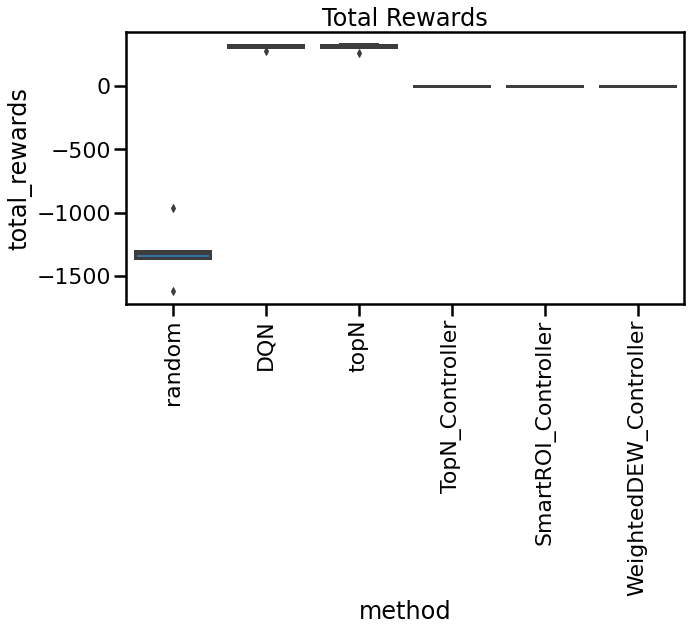

In [24]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='total_rewards')
plt.xticks(rotation=90)
plt.title('Total Rewards')

Text(0.5, 1.0, 'Invalid Action Count')

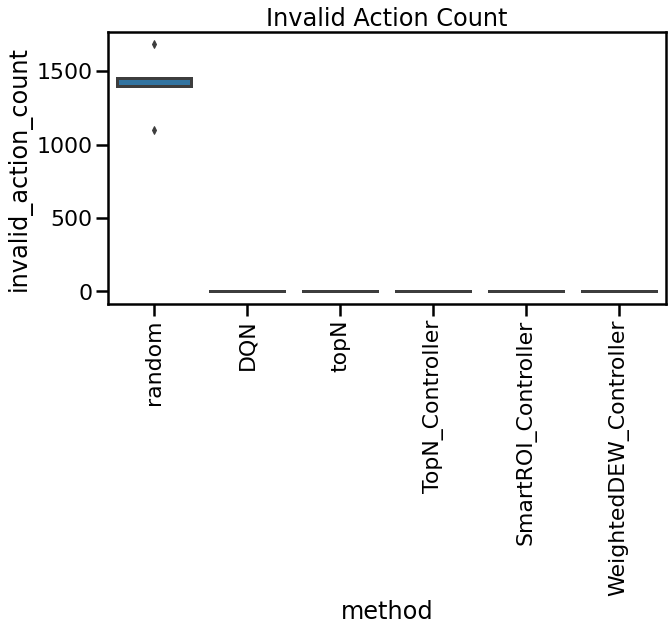

In [25]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='invalid_action_count')
plt.xticks(rotation=90)
plt.title('Invalid Action Count')

Text(0.5, 1.0, 'Coverage Proportion')

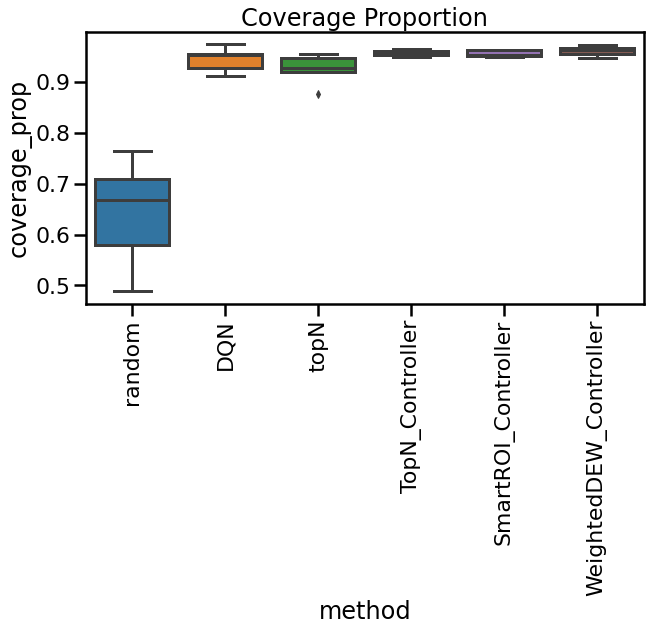

In [26]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='coverage_prop')
plt.xticks(rotation=90)
plt.title('Coverage Proportion')

Text(0.5, 1.0, 'Intensity Proportion')

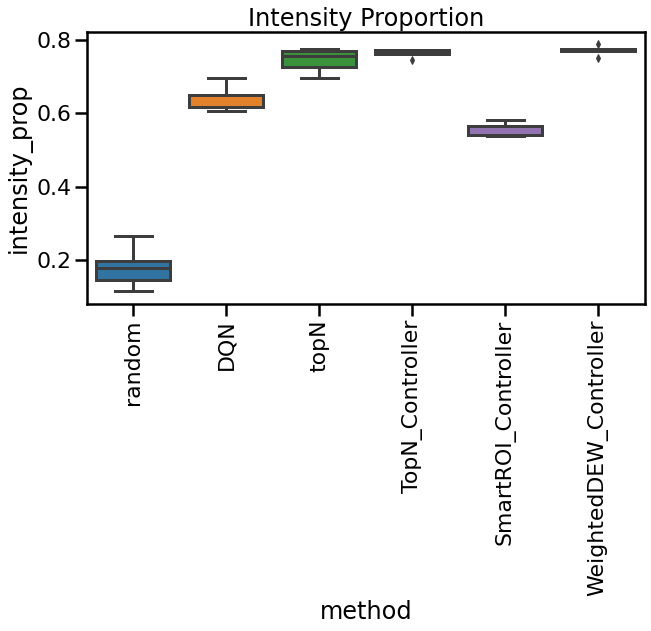

In [27]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='intensity_prop')
plt.xticks(rotation=90)
plt.title('Intensity Proportion')

Text(0.5, 1.0, 'MS1/MS2 Ratio')

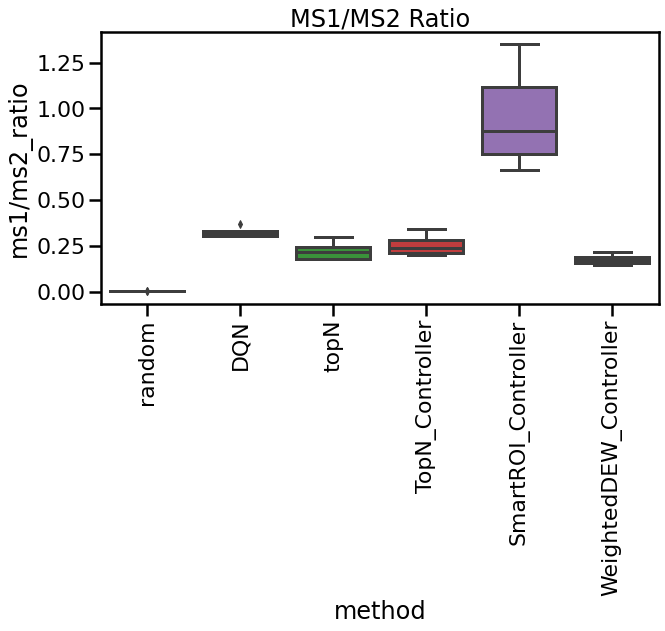

In [28]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='ms1/ms2_ratio')
plt.xticks(rotation=90)
plt.title('MS1/MS2 Ratio')

Text(0.5, 1.0, 'Efficiency')

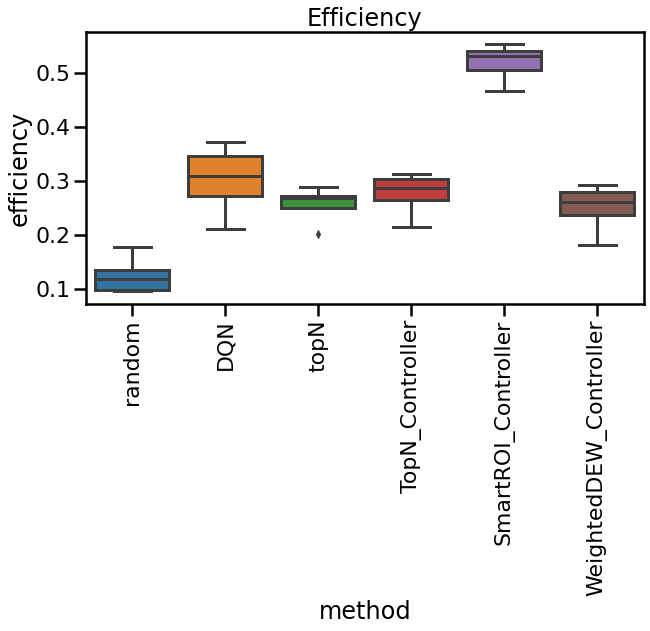

In [29]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='efficiency')
plt.xticks(rotation=90)
plt.title('Efficiency')

Text(0.5, 1.0, 'Precision')

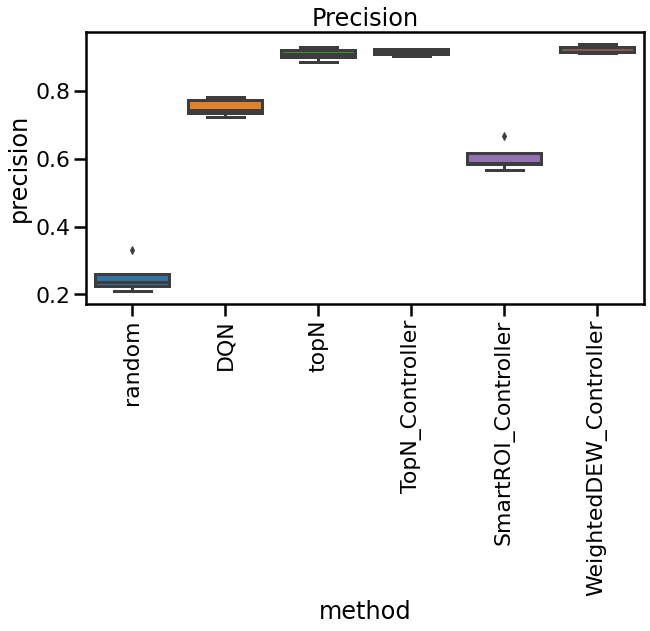

In [30]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='precision')
plt.xticks(rotation=90)
plt.title('Precision')

Text(0.5, 1.0, 'Recall')

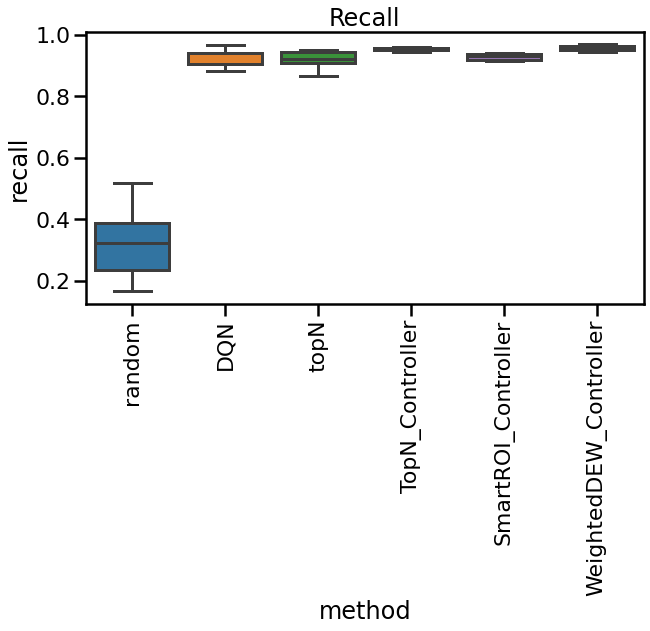

In [31]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='recall')
plt.xticks(rotation=90)
plt.title('Recall')

Text(0.5, 1.0, 'F1')

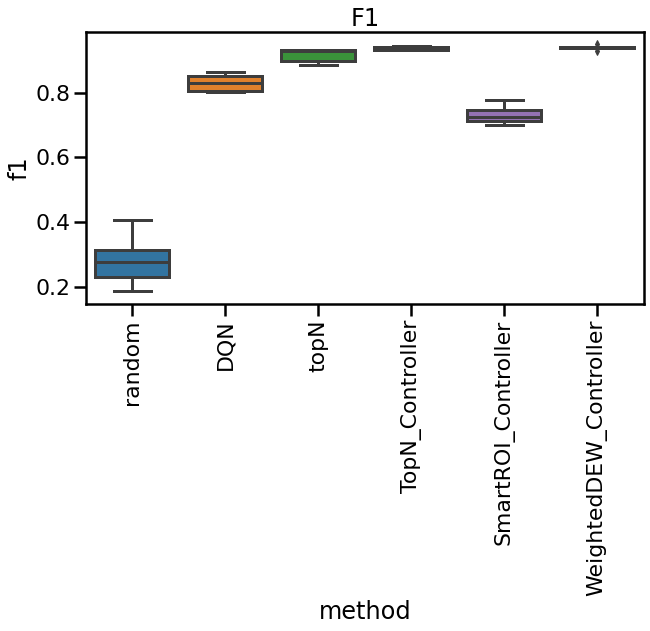

In [32]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='f1')
plt.xticks(rotation=90)
plt.title('F1')

In [33]:
df.to_pickle('evaluation_2.0E7.p')

### Without 'random'

In [34]:
df = pd.read_pickle('evaluation_2.0E7.p')

In [35]:
new_df = df[df.method != 'random']
new_df.head()

,method,total_rewards,invalid_action_count,coverage_prop,intensity_prop,ms1/ms2_ratio,efficiency,precision,recall,f1
5,DQN,279.515790,0.0,0.974,0.696,0.317,0.211,0.783,0.967,0.865
6,DQN,309.206248,0.0,0.955,0.651,0.305,0.271,0.744,0.940,0.831
7,DQN,326.908967,0.0,0.928,0.617,0.371,0.372,0.724,0.904,0.804
8,DQN,312.884982,0.0,0.953,0.649,0.306,0.309,0.775,0.940,0.850
9,DQN,325.615104,0.0,0.912,0.607,0.331,0.346,0.736,0.884,0.803


Text(0.5, 1.0, 'Total Rewards')

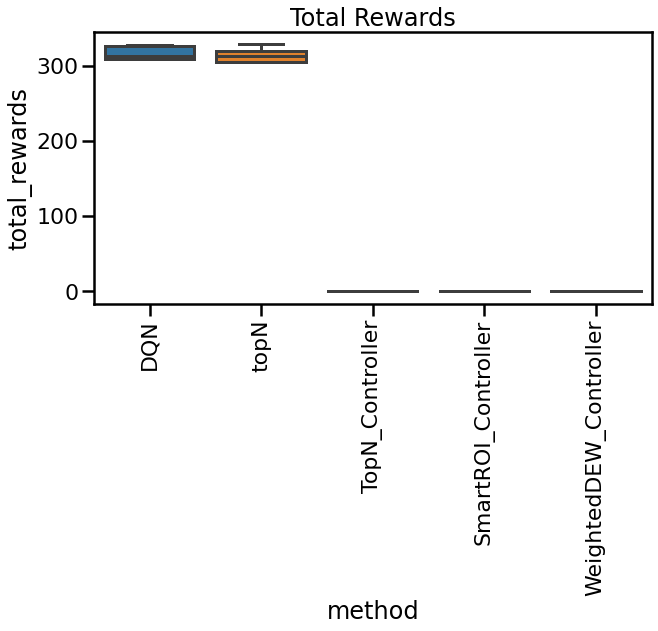

In [36]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=new_df, x='method', y='total_rewards', showfliers=False)
plt.xticks(rotation=90)
plt.title('Total Rewards')

Text(0.5, 1.0, 'Invalid Action Count')

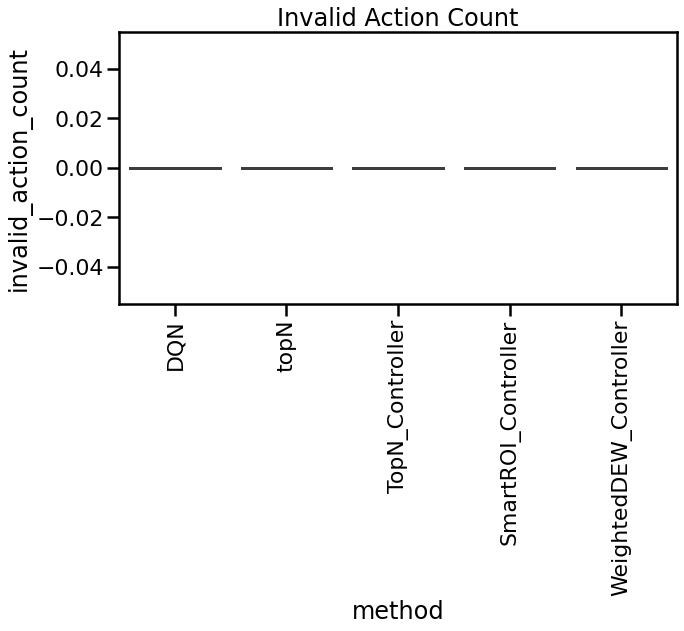

In [37]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=new_df, x='method', y='invalid_action_count', showfliers=False)
plt.xticks(rotation=90)
plt.title('Invalid Action Count')

Text(0.5, 1.0, 'Coverage Proportion')

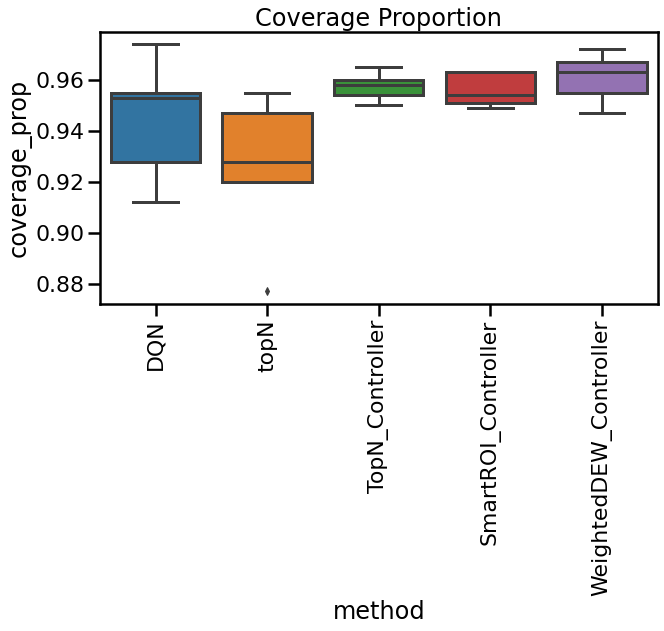

In [38]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=new_df, x='method', y='coverage_prop')
plt.xticks(rotation=90)
plt.title('Coverage Proportion')

Text(0.5, 1.0, 'Intensity Proportion')

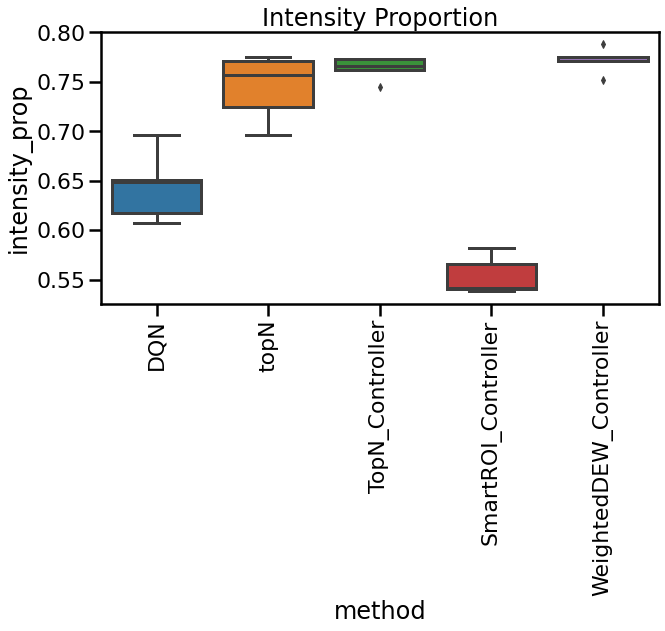

In [39]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=new_df, x='method', y='intensity_prop')
plt.xticks(rotation=90)
plt.title('Intensity Proportion')

Text(0.5, 1.0, 'MS1/MS2 Ratio')

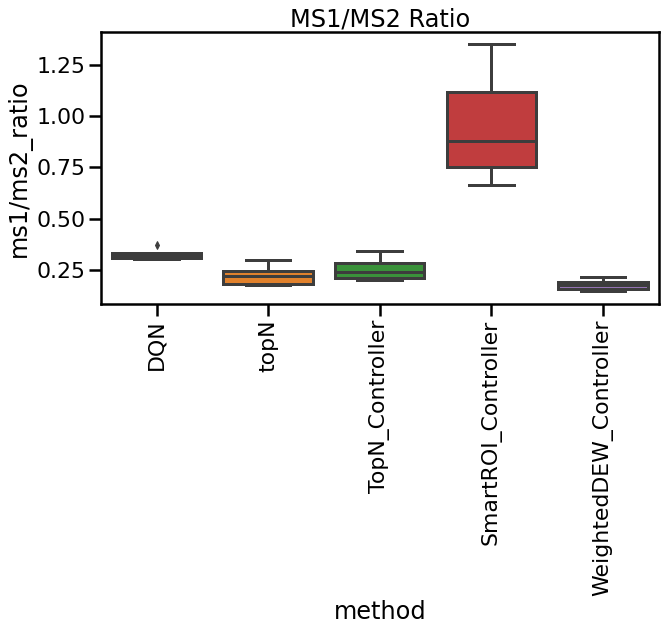

In [40]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=new_df, x='method', y='ms1/ms2_ratio')
plt.xticks(rotation=90)
plt.title('MS1/MS2 Ratio')

Text(0.5, 1.0, 'Precision')

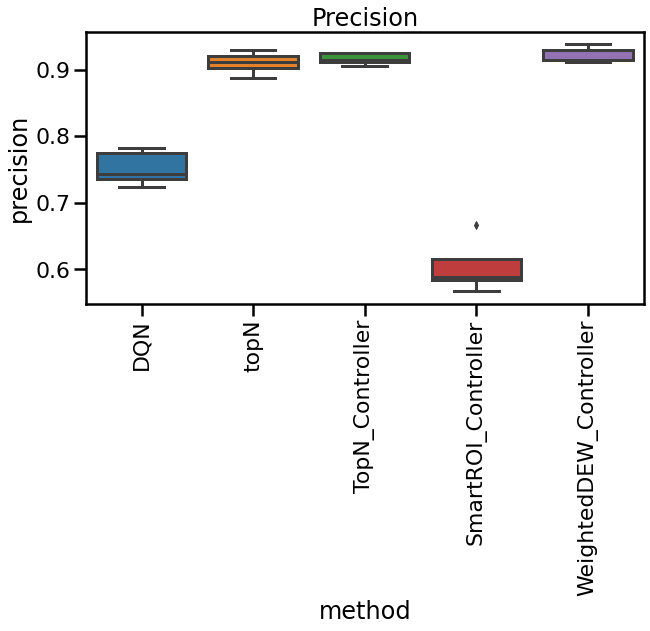

In [41]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=new_df, x='method', y='precision')
plt.xticks(rotation=90)
plt.title('Precision')

Text(0.5, 1.0, 'Recall')

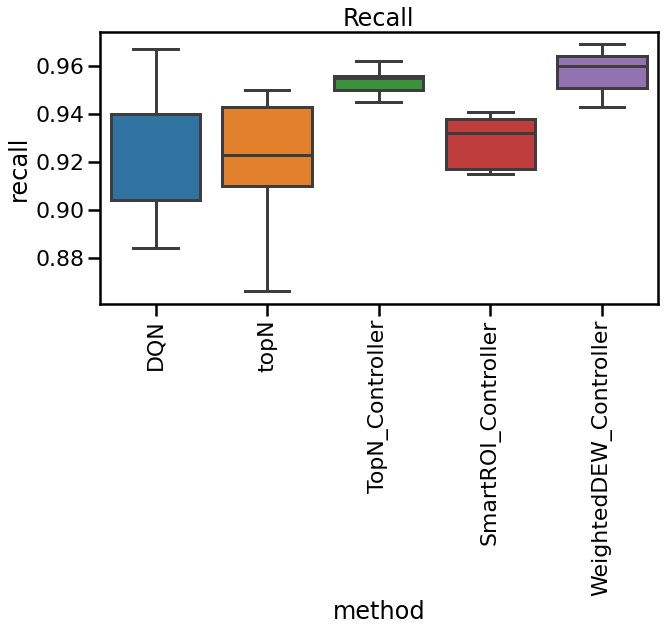

In [42]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=new_df, x='method', y='recall')
plt.xticks(rotation=90)
plt.title('Recall')

Text(0.5, 1.0, 'F1')

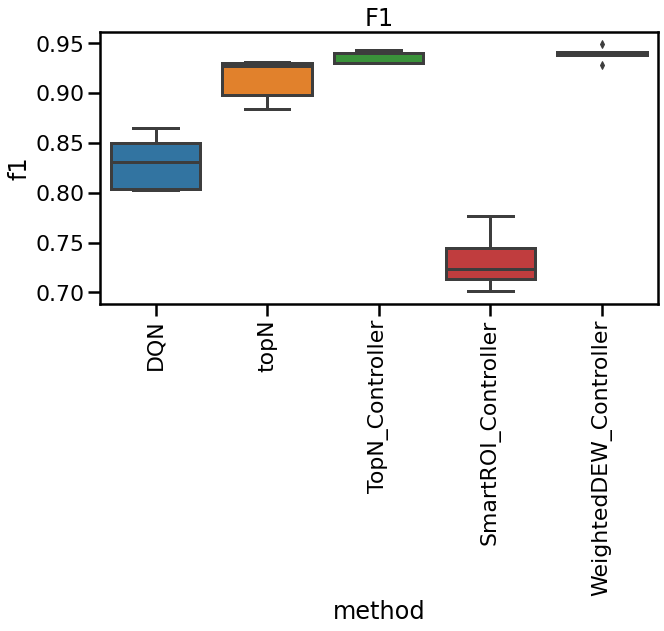

In [43]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=new_df, x='method', y='f1')
plt.xticks(rotation=90)
plt.title('F1')